# Dynamic Time Warping

In [51]:
from fastdtw import fastdtw
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

In [22]:
# Quick/easy illustration of DTW in practice
x = np.array([1, 2, 3, 3, 7])
y = np.array([1, 2, 67, 2, 2, 2, 2, 4])
y = np.array([1, 2.1, 3, 3, 7])
distance, path = fastdtw(x, y, dist=euclidean)
print(distance)

0.10000000000000009
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]


In [39]:
# Training Metadata
metadata_train = pd.read_csv('../metadata_train.csv')
train_signature_count = len(metadata_train)
print('No. of training signatures: ', train_signature_count)
damaged_indices = list(metadata_train.loc[(metadata_train['target']==1)].index)

count_undamag = len(metadata_train.loc[(metadata_train['target']==0)])
count_damaged = len(metadata_train.loc[(metadata_train['target']==1)])
print(f'Damaged: {count_damaged} of train_signature_count ({round(100*count_damaged/train_signature_count, 1)}%)')

No. of training signatures:  8712
Damaged: 525 of train_signature_count (6.0%)


In [24]:
phase0_ids = list(metadata_train.loc[(metadata_train['phase']==0)].signal_id)
phase1_ids = list(metadata_train.loc[(metadata_train['phase']==1)].signal_id)
phase2_ids = list(metadata_train.loc[(metadata_train['phase']==2)].signal_id)

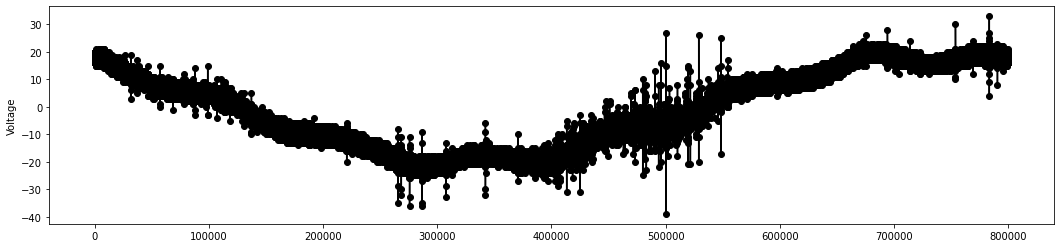

In [26]:
# Quick plot of the first signature 
signal_A = pq.read_table('../data/train.parquet', columns=[str(0)]).to_pandas()
signal_A.iloc[:,0].plot(figsize = (18, 4), color = 'black', marker = 'o')
plt.ylabel("Voltage")
plt.show()

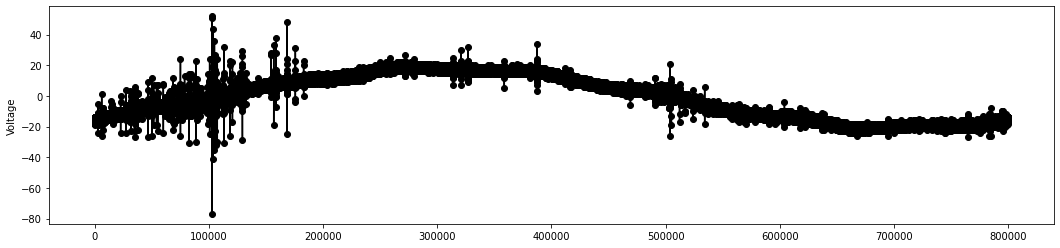

In [27]:
signal_B = pq.read_table('../data/train.parquet', columns=[str(3)]).to_pandas()
signal_B.iloc[:,0].plot(figsize = (18, 4), color = 'black', marker = 'o')
plt.ylabel("Voltage")
plt.show()

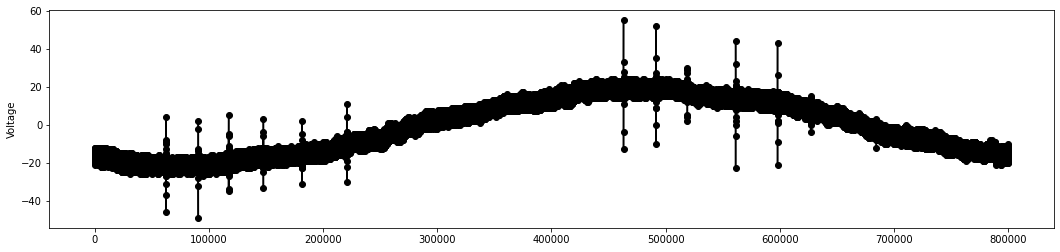

In [29]:
signal_C = pq.read_table('../data/train.parquet', columns=[str(6)]).to_pandas()
signal_C.iloc[:,0].plot(figsize = (18, 4), color = 'black', marker = 'o')
plt.ylabel("Voltage")
plt.show()

In [28]:
distance, path = fastdtw(signal_A, signal_B, dist=euclidean)
print(distance)

12286025.0


In [30]:
distance, path = fastdtw(signal_A, signal_C, dist=euclidean)
print(distance)

7585990.0


In [32]:
metadata_train.target.iloc[1]

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1
...,...,...,...,...
8707,8707,2902,1,0
8708,8708,2902,2,0
8709,8709,2903,0,0
8710,8710,2903,1,0


In [34]:
metadata_train.target.iloc[3]

1

In [82]:
compressed_signals = np.load('../data/compressed_signals.npy')

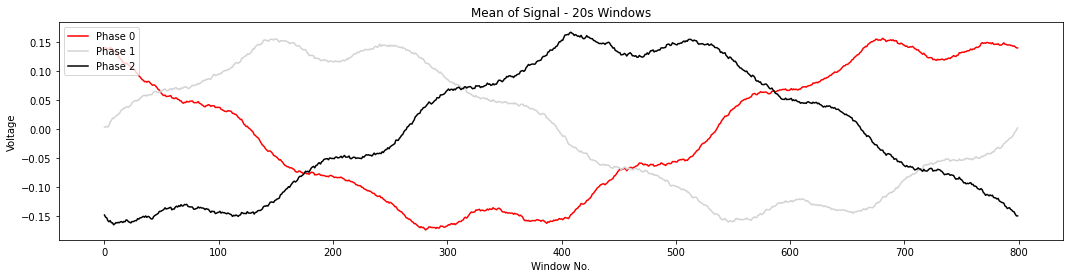

In [84]:
# Plot the compressed signatures for the 1st signal id (800 chunks & mean of raw signal)
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(compressed_signals[0, :], label='Phase 0', color = 'red')
ax.plot(compressed_signals[1, :], label='Phase 1', color = 'lightgrey')
ax.plot(compressed_signals[2, :], label='Phase 2', color = 'black')
ax.legend(loc = "upper left")
plt.ylabel("Voltage")
plt.xlabel("Window No.") 
plt.title("Mean of Signal - 20s Windows")
plt.show()

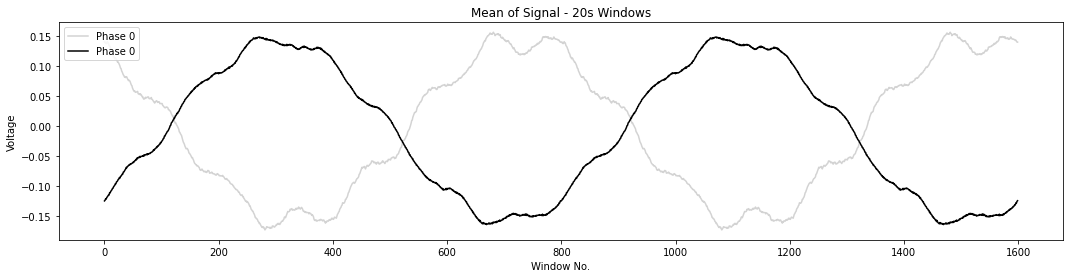

In [152]:
signal_A = np.concatenate((compressed_signals[0, :], compressed_signals[0, :]))
signal_B = np.concatenate((compressed_signals[3, :], compressed_signals[3, :]))
#signal_B = np.concatenate((compressed_signals[294, :], compressed_signals[294, :]))
#signal_B = np.concatenate((compressed_signals[408, :], compressed_signals[408, :]))

fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(signal_A, label='Phase 0', color = 'lightgrey')
ax.plot(signal_B, label='Phase 0', color = 'black')
ax.legend(loc = "upper left")
plt.ylabel("Voltage")
plt.xlabel("Window No.") 
plt.title("Mean of Signal - 20s Windows")
plt.show()

In [153]:
distance, path = fastdtw(signal_A, signal_B, dist=euclidean)
distance

99.58893022767734

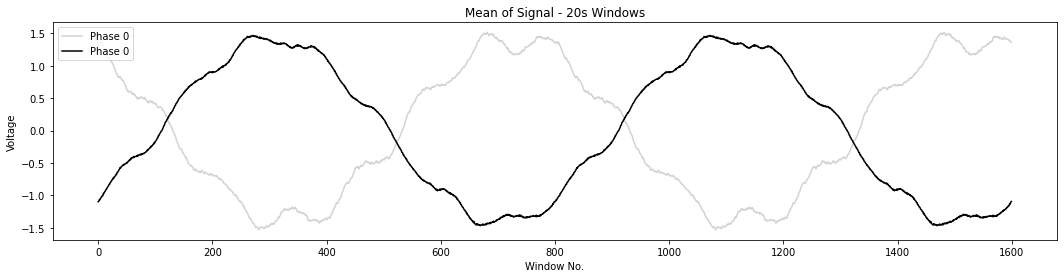

In [154]:
from scipy import stats
import dtaidistance
from dtaidistance import dtw
az = stats.zscore(signal_A)
ay = stats.zscore(signal_B)
#az = dtaidistance.preprocessing.differencing(az, smooth=0.1)

fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(az, label='Phase 0', color = 'lightgrey')
ax.plot(ay, label='Phase 0', color = 'black')
ax.legend(loc = "upper left")
plt.ylabel("Voltage")
plt.xlabel("Window No.") 
plt.title("Mean of Signal - 20s Windows")
plt.show()

In [121]:
distance, paths = dtw.warping_paths(az, ay)
print(distance)

40.88313776354486


In [155]:
df = pd.DataFrame()
df['az'] = az
df['ay'] = ay

In [ ]:
distance, path = fastdtw(base_signal, signal_test, dist=euclidean)

In [158]:
def crossdtw(datax, datay, lag=0):
    datay = datay.shift(lag)
    distance, _ = fastdtw(datax, signal_test, dist=euclidean)
    return(distance)

In [156]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

d1 = df['az']
d2 = df['ay']
rs = [crosscorr(d1, d2, lag) for lag in range(-int(400), int(400))]
offset = np.floor(len(rs)/2)-np.argmax(rs)

In [162]:
from tqdm.notebook import tqdm
d1 = df['az']
d2 = df['ay']
rs = [crossdtw(d1, d2, lag) for lag in tqdm(range(-int(200), int(200)))]

  0%|          | 0/400 [00:00<?, ?it/s]

In [163]:
print(max(rs))
print(min(rs))

1227.1656356168678
1227.1656356168678
